In [1]:
# configure udtk as parent folder
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from udtk import clustering, viz
import geopandas as gpd
from matplotlib.colors import ListedColormap
%matplotlib inline

/home/federico/anaconda3/envs/udtk/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/federico/anaconda3/envs/udtk/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
df = gpd.read_file('../carto/h3_aggregated_8.geojson')
df.head()

,h3_res_8,RetailArea,NumBldgs,geometry
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854..."
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801..."
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793..."
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795..."
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806..."


In [4]:
w = clustering.read_w_from_pickle('../data/w.pickle')

In [5]:
gdf = clustering.get_lisa(df, 'RetailArea', w)

('WARNING: ', '882a1072b9fffff', ' is an island (no neighbors)')


In [6]:
gdf

,h3_res_8,RetailArea,NumBldgs,geometry,lisa_cluster
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854...",Non-significant
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801...",Non-significant
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793...",LL
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795...",Non-significant
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806...",Non-significant
...,...,...,...,...,...
108,882a1072cbfffff,2239.665154,1195,"POLYGON ((-73.98904 40.72516, -73.99541 40.724...",Non-significant
109,882a1072cdfffff,1188.193370,1448,"POLYGON ((-74.00227 40.73538, -74.00865 40.734...",Non-significant
110,882a1072d5fffff,6036.421687,107,"POLYGON ((-73.99493 40.71179, -74.00130 40.710...",Non-significant
111,882a1072d9fffff,1391.133333,29,"POLYGON ((-73.97580 40.71495, -73.98218 40.713...",Non-significant


In [7]:
from sklearn.cluster import DBSCAN

In [8]:
gdf.lisa_cluster.unique()

array(['Non-significant', 'LL', 'HH', 'HL'], dtype=object)

In [15]:
gdf.head()

,h3_res_8,RetailArea,NumBldgs,geometry,lisa_cluster
0,882a10085bfffff,0.000000,0,"POLYGON ((-73.94913 40.85585, -73.95552 40.854...",Non-significant
1,882a100881fffff,1264.331034,326,"POLYGON ((-73.97278 40.80229, -73.97917 40.801...",Non-significant
2,882a100883fffff,895.141372,1040,"POLYGON ((-73.97033 40.79441, -73.97672 40.793...",LL
3,882a100887fffff,4.411765,106,"POLYGON ((-73.98114 40.79677, -73.98752 40.795...",Non-significant
4,882a100889fffff,998.530957,570,"POLYGON ((-73.96443 40.80780, -73.97081 40.806...",Non-significant


In [31]:
len(quadrants)

26

In [32]:
test = 

In [61]:
def get_dbscan(gdf, distance, nbours):
    '''
    This function returns the DBSCAN computed cluster label for high-high & low-low 
    quadrants.
    ...
    gdf(geodataframe): fgd with a 'lisa_cluster' label that indicates the quadrant of each grid.
    distance(float): the amount of kms per radian. Ej:0.5 represents a radius of 500mts.
    nbours(int): the amount of neighbours to be computed in min_samples parameter.
    
    '''
    
    # high-high & low-low quadrants
    quadrants = gdf.loc[(gdf['lisa_cluster'] == 'HH') | (gdf['lisa_cluster'] == 'LL')]
    # gdf coordinates
    list_q = list(quadrants.centroid.map(lambda g: [g.x, g.y]))
    
    kms_per_radian = 6371.0088
    eps_val = distance / kms_per_radian
    
    clustering_quadrant = DBSCAN(eps=eps_val, min_samples=nbours).fit(list_q)
    
    labels = clustering_quadrant.labels_
    
    return labels

In [62]:
get_dbscan(gdf,0.9,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [13]:
#from udtk.clustering import get_dbscan

In [8]:
clustering.get_dbscan(gdf)

AttributeError: module 'udtk.clustering' has no attribute 'get_dbscan'

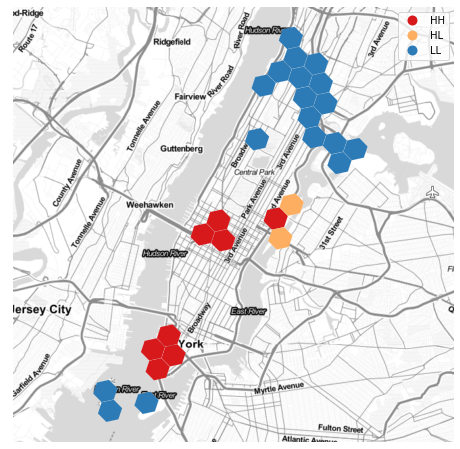

In [5]:
viz.plot_lisa(gdf)

In [6]:
from pysal.explore.esda.moran import Moran_Local


In [7]:
Moran_Local?